ARIMAX extends the traditional ARIMA by incorporating additional exogenous (external) variable

Insert necessary libraries

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# ARIMA model for time series forecasting
from statsmodels.tsa.arima.model import ARIMA
#Seasonal Arima model for time series forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Statistical modeling tools
import statsmodels.api as sm

# Metrics for model evaluation (MSE, R², accuracy, recall, precision)
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score

# Plotting for visualization
import matplotlib.pyplot as plt

# Grid search and warnings handling
import itertools
import warnings




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read file

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/finaldatasets.csv')
df.head()

,Time,Rainfall,Temperature,Humidity,Cases
0,2016-w1,0.034,28.100000,81.671429,19
1,2016-w2,0.000,28.310000,81.685714,23
2,2016-w3,0.000,28.033333,80.400000,31
3,2016-w4,0.420,26.527778,85.985714,26
4,2016-w5,5.660,27.444440,84.680000,10


Initialize Columns

In [ ]:
df.columns=["Time", "Rainfall", "Temperature", "Humidity", "Cases"]
df.head()

,Time,Rainfall,Temperature,Humidity,Cases
0,2016-w1,0.034,28.100000,81.671429,19
1,2016-w2,0.000,28.310000,81.685714,23
2,2016-w3,0.000,28.033333,80.400000,31
3,2016-w4,0.420,26.527778,85.985714,26
4,2016-w5,5.660,27.444440,84.680000,10


Convert  time data into a proper datetime format

In [ ]:
df['Time'] = pd.to_datetime(df['Time'] + '-1', format='%Y-w%W-%w')

Convert all data into numeric

In [ ]:
df['Rainfall'] = pd.to_numeric(df['Rainfall'], errors='coerce')
df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
df['Cases'] = pd.to_numeric(df['Cases'], errors='coerce')
df['Humidity'] = pd.to_numeric(df['Humidity'], errors='coerce')

df.replace([np.inf, -np.inf], np.nan, inplace=True)

df.dropna(inplace=True)

SPLIT THE DATA

In [ ]:
train_size = int(len(df) * 0.8)  # 80% for training
train, test = df.iloc[:train_size], df.iloc[train_size:]

Seperate Variables

In [ ]:
y = df['Cases']  # Dependent variable
X = df[['Rainfall', 'Temperature', 'Humidity']]  # regressor variables

Find the Best AR Term Differencing and MA term

In [ ]:
# Ignore specific ARIMA warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define the p, d, q ranges to test
p_values = range(0, 4)  # Test p = 0, 1, 2, 3
d_values = range(0, 3)  # Test d = 0, 1, 2
q_values = range(0, 4)  # Test q = 0, 1, 2, 3

# Prepare exogenous variables
X_train = train[['Rainfall', 'Temperature', 'Humidity']]
X_test = test[['Rainfall', 'Temperature', 'Humidity']]

best_score, best_cfg = float("inf"), None

# Grid search for the best parameters
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        # Define ARIMA model
        model = ARIMA(train['Cases'], exog=X_train, order=(p, d, q),
                      enforce_stationarity=False, enforce_invertibility=False)

        # Fit the model with a max of 400 iterations
        model_fit = model.fit(method_kwargs={'maxiter': 400, 'disp': 0})

        # Forecast
        y_pred = model_fit.forecast(steps=len(test), exog=X_test)

        # Calculate error
        error = mean_squared_error(test['Cases'], y_pred)

        # Compare and store the best p, d, q
        if error < best_score:
            best_score, best_cfg = error, (p, d, q)
        print(f"ARIMA{(p, d, q)} - MSE: {error:.6f}")
    except Exception as e:
        print(f"ARIMA{(p, d, q)} failed: {str(e)}")
        continue

print(f'Best ARIMA{best_cfg} with MSE: {best_score:.6f}')

# Fit the best ARIMA model with the selected (p, d, q)
if best_cfg is not None:
    p, d, q = best_cfg

    model = ARIMA(train['Cases'], exog=X_train, order=(p, d, q))
    model_fit = model.fit()

    # Forecasting
    predictions = model_fit.forecast(steps=len(test), exog=X_test)

    # Check for NaN values
    if predictions.isna().any():
        print("Predicted Cases contains NaN values. Check the model fit and the input data.")
        print(f"Predictions: {predictions}")  # Check what the predictions are
    else:
        # Directly assign predictions to the test DataFrame using .loc
        test.loc[:, 'Predicted_Cases'] = predictions


ARIMA(0, 0, 0) - MSE: 2294.161144
ARIMA(0, 0, 1) - MSE: 2275.581888
ARIMA(0, 0, 2) - MSE: 2242.596304
ARIMA(0, 0, 3) - MSE: 2226.002829
ARIMA(0, 1, 0) - MSE: 2693.566480
ARIMA(0, 1, 1) - MSE: 2673.568373
ARIMA(0, 1, 2) - MSE: 2803.464687
ARIMA(0, 1, 3) - MSE: 2858.739642
ARIMA(0, 2, 0) - MSE: 9909.453698
ARIMA(0, 2, 1) - MSE: 2770.561413
ARIMA(0, 2, 2) - MSE: 2767.654349
ARIMA(0, 2, 3) - MSE: 3057.758837
ARIMA(1, 0, 0) - MSE: 2207.284666
ARIMA(1, 0, 1) - MSE: 2130.382278
ARIMA(1, 0, 2) - MSE: 2199.618885
ARIMA(1, 0, 3) - MSE: 2194.526533
ARIMA(1, 1, 0) - MSE: 2673.898731
ARIMA(1, 1, 1) - MSE: 2757.271229
ARIMA(1, 1, 2) - MSE: 2905.709366
ARIMA(1, 1, 3) - MSE: 2907.902408
ARIMA(1, 2, 0) - MSE: 43590.744696
ARIMA(1, 2, 1) - MSE: 2786.048309
ARIMA(1, 2, 2) - MSE: 2732.239437
ARIMA(1, 2, 3) - MSE: 3231.488945
ARIMA(2, 0, 0) - MSE: 2137.222755
ARIMA(2, 0, 1) - MSE: 2205.636326
ARIMA(2, 0, 2) - MSE: 2185.599943
ARIMA(2, 0, 3) - MSE: 2174.363238
ARIMA(2, 1, 0) - MSE: 2840.216150
ARIMA(2, 1, 1

<ipython-input-9-8a2228ac835d>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Predicted_Cases'] = predictions


DISPLAY THE PLOT

In [ ]:
test

,Time,Rainfall,Temperature,Humidity,Cases,Predicted_Cases
320,2023-02-20,0.01,25.727778,87.11429,6,11.888021
321,2023-02-27,0.20,26.877778,80.15714,8,13.599172
322,2023-03-06,0.00,27.538889,77.85714,15,14.804506
323,2023-03-13,0.00,28.305556,80.22857,11,15.113618
324,2023-03-20,0.00,29.383333,78.24286,12,15.962256
...,...,...,...,...,...,...
395,2024-08-05,0.03,28.116667,84.92857,226,24.226216
396,2024-08-12,0.70,29.288889,85.48571,205,23.597406
397,2024-08-19,0.12,29.355556,82.41429,209,24.326285
398,2024-08-26,0.45,28.305556,83.22857,162,24.258136


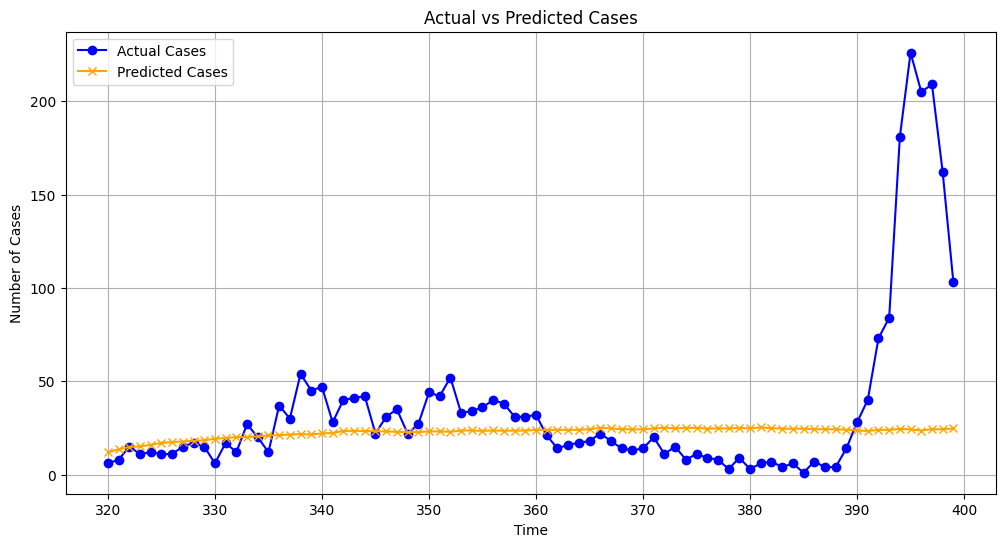

In [ ]:
# Safely assign predictions to the 'Predicted_Cases' column using .loc
test.loc[:, 'Predicted_Cases'] = predictions

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Cases'], label='Actual Cases', color='blue', marker='o')
plt.plot(test.index, test['Predicted_Cases'], label='Predicted Cases', color='orange', marker='x')
plt.title('Actual vs Predicted Cases')
plt.xlabel('Time')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid()
plt.show()


Evaluate the Model MSE

In [ ]:
# MSE
mse = mean_squared_error(test['Cases'], test['Predicted_Cases'])
print(f'Mean Squared Error (MSE): {mse:.6f}')

# RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

# R-squared
r2 = r2_score(test['Cases'], test['Predicted_Cases'])
print(f'R-squared (R2): {r2:.6f}')

# Make a copy of the test DataFrame to avoid SettingWithCopyWarning
test_copy = test.copy()

threshold = 0

# Safely assign binary classification using .loc on the copy
test_copy.loc[:, 'Actual_Class'] = (test_copy['Cases'] > threshold).astype(int)
test_copy.loc[:, 'Predicted_Class'] = (test_copy['Predicted_Cases'] > threshold).astype(int)

# Accuracy
accuracy = accuracy_score(test_copy['Actual_Class'], test_copy['Predicted_Class'])
print(f'Accuracy: {accuracy:.6f}')

# Recall
recall = recall_score(test_copy['Actual_Class'], test_copy['Predicted_Class'])
print(f'Recall: {recall:.6f}')

# Precision
precision = precision_score(test_copy['Actual_Class'], test_copy['Predicted_Class'])
print(f'Precision: {precision:.6f}')


Mean Squared Error (MSE): 2212.400731
Root Mean Squared Error (RMSE): 47.036164
R-squared (R2): -0.047316
Accuracy: 1.000000
Recall: 1.000000
Precision: 1.000000


Display the Plot for metrics

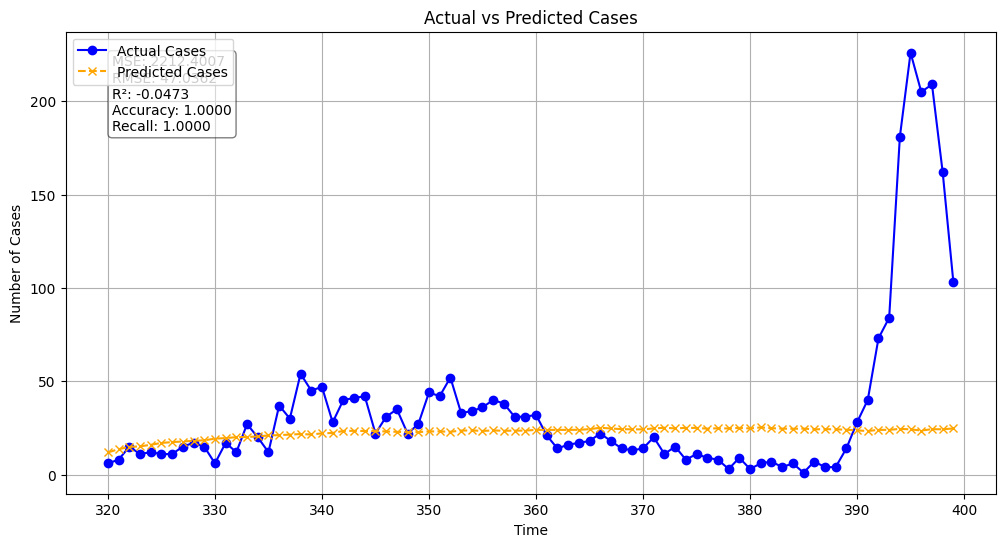

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Cases'], label='Actual Cases', color='blue', marker='o', linestyle='-')
plt.plot(test.index, test['Predicted_Cases'], label='Predicted Cases', color='orange', marker='x', linestyle='--')

# Add labels and title
plt.title('Actual vs Predicted Cases')
plt.xlabel('Time')
plt.ylabel('Number of Cases')

# Add text box to display metrics on the plot
textstr = f'MSE: {mse:.4f}\nRMSE: {rmse:.4f}\nR²: {r2:.4f}\nAccuracy: {accuracy:.4f}\nRecall: {recall:.4f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props)

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Compare Actual Values Vs. Predicted

In [ ]:
results = pd.DataFrame({
    'Predicted Cases': predictions.values,
    'Actual Cases': test['Cases'].reset_index(drop=True)
})
results.head()

,Predicted Cases,Actual Cases
0,11.888021,6
1,13.599172,8
2,14.804506,15
3,15.113618,11
4,15.962256,12


Plot the results

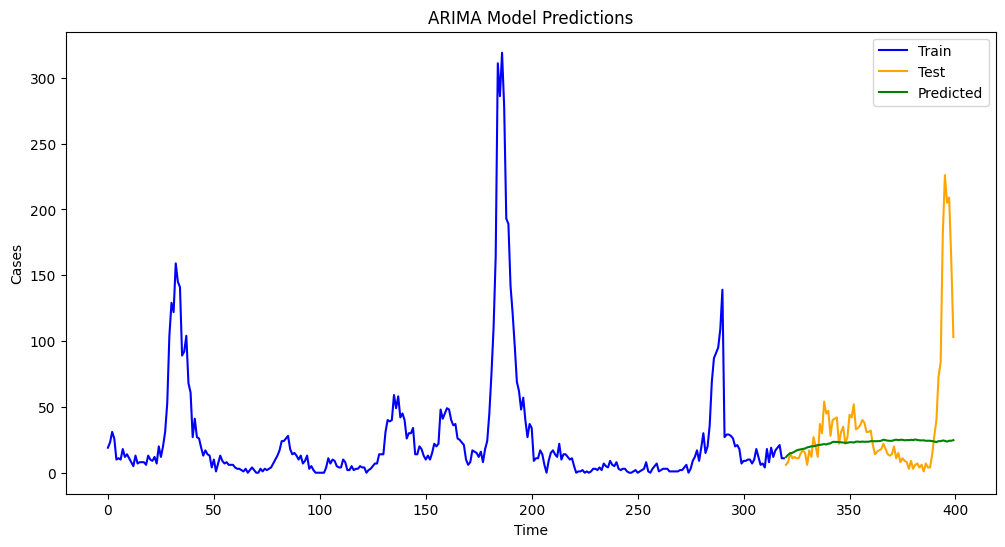

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Cases'], label='Train', color='blue')
plt.plot(test.index, test['Cases'], label='Test', color='orange')
plt.plot(test.index, test['Predicted_Cases'], label='Predicted', color='green')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()

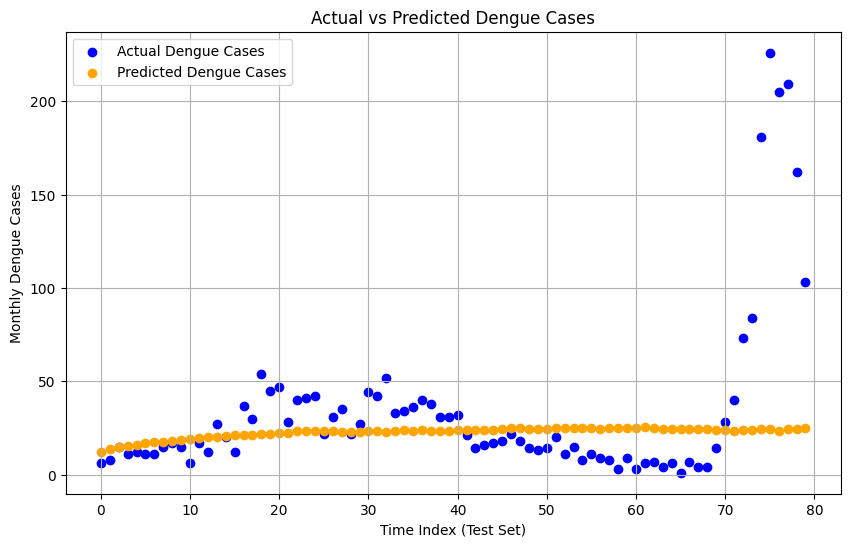

In [ ]:
# Plot: Actual vs Predicted values with different colors
plt.figure(figsize=(10, 6))

# Plot actual values
plt.scatter(np.arange(len(test['Cases'])), test['Cases'], color='blue', label='Actual Dengue Cases')

# Plot predicted values
plt.scatter(np.arange(len(test['Predicted_Cases'])), test['Predicted_Cases'], color='orange', label='Predicted Dengue Cases')

# Add title and labels
plt.title('Actual vs Predicted Dengue Cases')
plt.xlabel('Time Index (Test Set)')
plt.ylabel('Monthly Dengue Cases')

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Temperature vs Cases

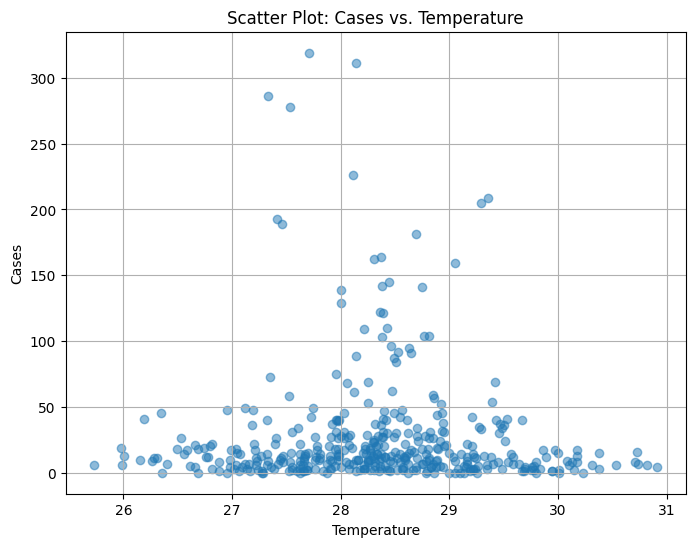

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Temperature'], df['Cases'], alpha=0.5)  # Alpha for transparency

plt.xlabel('Temperature')
plt.ylabel('Cases')
plt.title('Scatter Plot: Cases vs. Temperature')
plt.grid(True)
plt.show()

Rainfall vs Cases

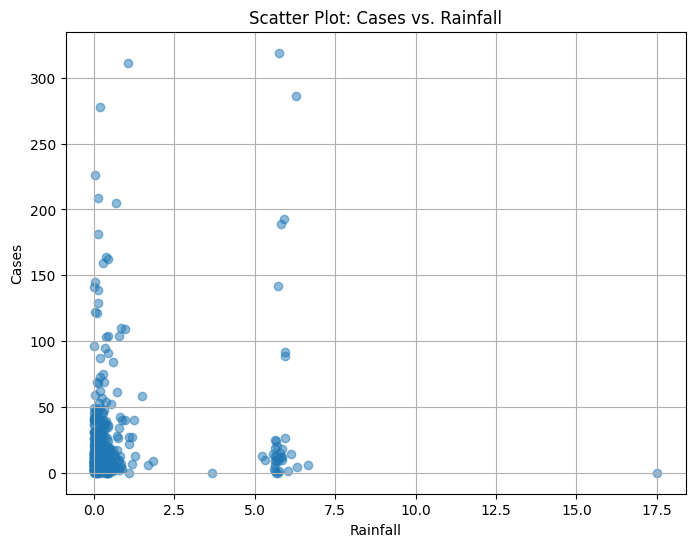

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Rainfall'], df['Cases'], alpha=0.5)  # Alpha for transparency

plt.xlabel('Rainfall')
plt.ylabel('Cases')
plt.title('Scatter Plot: Cases vs. Rainfall')
plt.grid(True)
plt.show()

Cases Vs Humidity

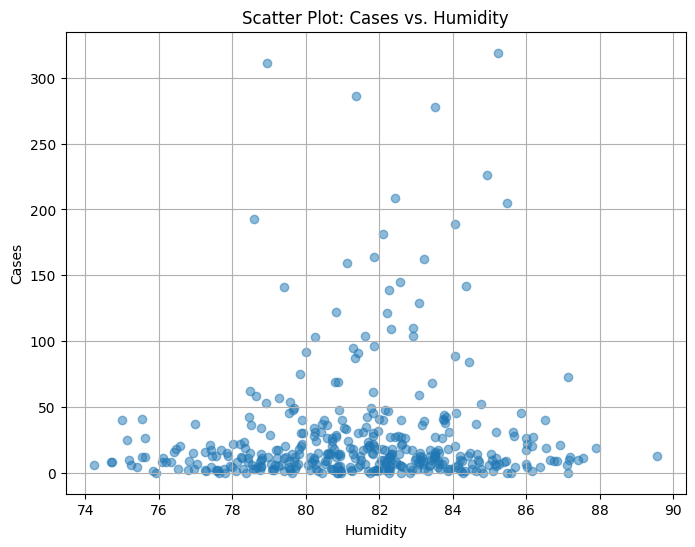

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Humidity'], df['Cases'], alpha=0.5)

plt.xlabel('Humidity')
plt.ylabel('Cases')
plt.title('Scatter Plot: Cases vs. Humidity')
plt.grid(True)
plt.show()

Seasonal Arima  SARIMA Model

In [ ]:
# import itertools
# import warnings
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Ignore specific ARIMA warnings
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.simplefilter(action='ignore', category=FutureWarning)

# # Optimal p, d, q, P, D, Q ranges to test
# p_values = range(0, 3)  # p = 0, 1, 2
# d_values = range(0, 2)  # d = 0, 1
# q_values = range(0, 3)  # q = 0, 1, 2

# P_values = range(0, 3)  # P = 0, 1, 2
# D_values = [1]          # D = 1 (seasonal differencing)
# Q_values = range(0, 3)  # Q = 0, 1, 2

# m = 52  # seasonal period is 52 weeks (1 year)


# # Prepare exogenous variables
# X_train = train[['Rainfall', 'Temperature', 'Humidity']]
# X_test = test[['Rainfall', 'Temperature', 'Humidity']]

# best_score, best_cfg, best_seasonal_cfg = float("inf"), None, None

# # Grid search for the best seasonal ARIMA parameters
# for p, d, q in itertools.product(p_values, d_values, q_values):
#     for P, D, Q in itertools.product(P_values, D_values, Q_values):
#         try:
#             # Define SARIMA model
#             model = SARIMAX(train['Cases'], exog=X_train, order=(p, d, q),
#                             seasonal_order=(P, D, Q, m), enforce_stationarity=False, enforce_invertibility=False)

#             # Fit the model with a max of 400 iterations
#             model_fit = model.fit(method_kwargs={'maxiter': 400, 'disp': 0})

#             # Forecast
#             y_pred = model_fit.forecast(steps=len(test), exog=X_test)

#             # Calculate error
#             error = mean_squared_error(test['Cases'], y_pred)

#             # Compare and store the best p, d, q, and seasonal (P, D, Q)
#             if error < best_score:
#                 best_score, best_cfg, best_seasonal_cfg = error, (p, d, q), (P, D, Q, m)
#             print(f"SARIMA{(p, d, q)}x{(P, D, Q, m)} - MSE: {error:.6f}")
#         except Exception as e:
#             print(f"SARIMA{(p, d, q)}x{(P, D, Q, m)} failed: {str(e)}")
#             continue

# print(f'Best SARIMA{best_cfg}x{best_seasonal_cfg} with MSE: {best_score:.6f}')

# # Fit the best SARIMA model with the selected (p, d, q) and seasonal (P, D, Q)
# if best_cfg is not None and best_seasonal_cfg is not None:
#     p, d, q = best_cfg
#     P, D, Q, m = best_seasonal_cfg

#     model = SARIMAX(train['Cases'], exog=X_train, order=(p, d, q), seasonal_order=(P, D, Q, m))
#     model_fit = model.fit()

#     # Forecasting
#     predictions = model_fit.forecast(steps=len(test), exog=X_test)

After the grid search we found out that best sarima parameters are (2, 0, 2)x(0, 1, 1, 52)

In [ ]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Ignore specific ARIMA warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define SARIMA parameters
order = (2, 0, 2)
seasonal_order = (0, 1, 1, 52)

# Prepare exogenous variables
X_train = train[['Rainfall', 'Temperature', 'Humidity']]
X_test = test[['Rainfall', 'Temperature', 'Humidity']]

# Define and fit the SARIMA model
model = SARIMAX(train['Cases'], exog=X_train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)

# Fit the model with a max of 400 iterations
model_fit = model.fit(method_kwargs={'maxiter': 400, 'disp': 0})

# Forecasting
predictions = model_fit.forecast(steps=len(test), exog=X_test)

# Calculate error
error = mean_squared_error(test['Cases'], predictions)
print(f"SARIMA{order}x{seasonal_order} - MSE: {error:.6f}")


SARIMA(2, 0, 2)x(0, 1, 1, 52) - MSE: 1228.276754


 Evaluation (MSE, RMSE, R², Accuracy, Precision, Recall)

In [ ]:
# Check for NaN values in predictions
if predictions.isna().any():
    print("Predicted Cases contains NaN values. Check the model fit and the input data.")
else:
    # Calculate evaluation metrics
    mse = mean_squared_error(test['Cases'], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test['Cases'], predictions)

    # Set a threshold for binary classification (adjust based on your use case)
    threshold = 100  # Example threshold for "outbreak"
    actual_classes = np.where(test['Cases'] > threshold, 1, 0)
    predicted_classes = np.where(predictions > threshold, 1, 0)

    accuracy = accuracy_score(actual_classes, predicted_classes)
    precision = precision_score(actual_classes, predicted_classes)
    recall = recall_score(actual_classes, predicted_classes)

    # Print evaluation results
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"R²: {r2:.6f}")
    print(f"Accuracy: {accuracy:.6f}")
    print(f"Precision: {precision:.6f}")
    print(f"Recall: {recall:.6f}")


MSE: 1228.276754
RMSE: 35.046780
R²: 0.418553
Accuracy: 0.925000
Precision: 0.500000
Recall: 0.166667


Actual vs Predicted Values

In [ ]:
results = pd.DataFrame({
    'Predicted Cases': predictions.values,
    'Actual Cases': test['Cases'].reset_index(drop=True)
})
results.head()

,Predicted Cases,Actual Cases
0,8.257269,6
1,6.517691,8
2,6.113448,15
3,6.312371,11
4,5.308835,12


Display Plot

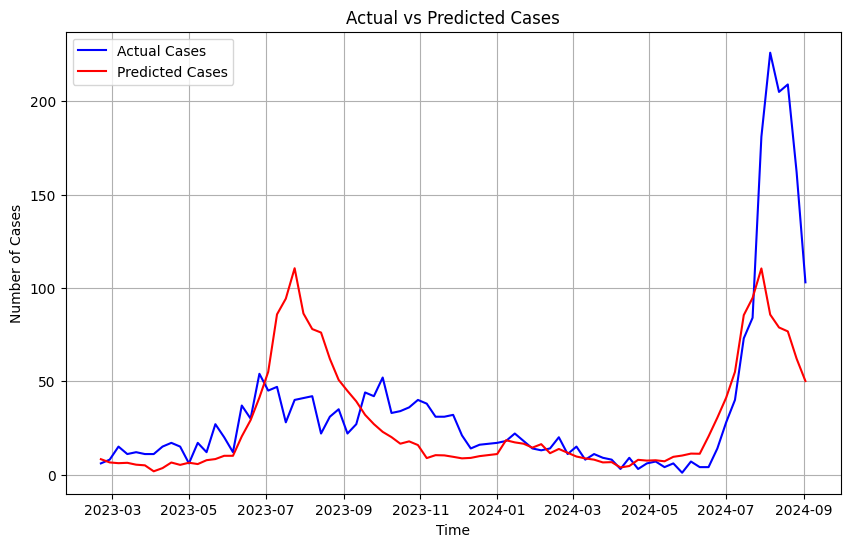

In [ ]:
# Plotting the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(test['Time'], test['Cases'], label='Actual Cases', color='blue')
plt.plot(test['Time'], predictions, label='Predicted Cases', color='red')
plt.xlabel('Time')
plt.ylabel('Number of Cases')
plt.title('Actual vs Predicted Cases')
plt.legend()
plt.grid(True)
plt.show()


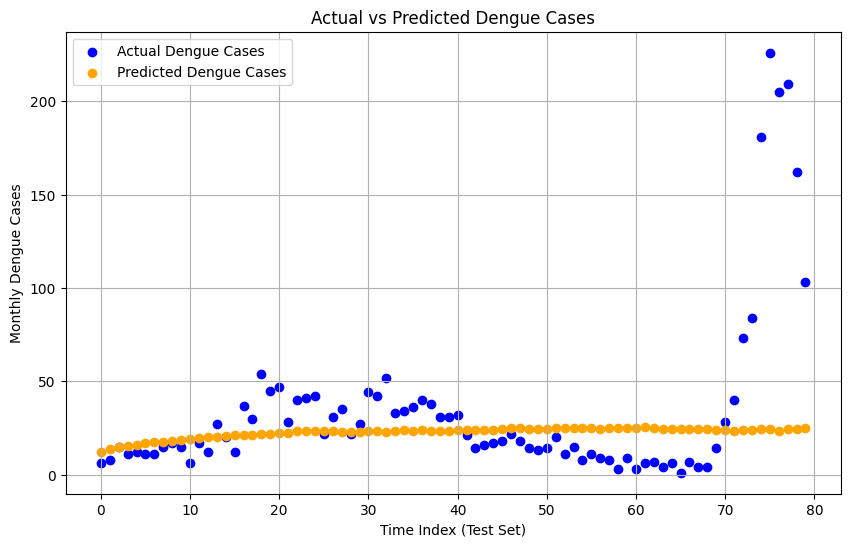

In [ ]:
# Plot: Actual vs Predicted values with different colors
plt.figure(figsize=(10, 6))

# Plot actual values
plt.scatter(np.arange(len(test['Cases'])), test['Cases'], color='blue', label='Actual Dengue Cases')

# Plot predicted values
plt.scatter(np.arange(len(test['Predicted_Cases'])), test['Predicted_Cases'], color='orange', label='Predicted Dengue Cases')

# Add title and labels
plt.title('Actual vs Predicted Dengue Cases')
plt.xlabel('Time Index (Test Set)')
plt.ylabel('Monthly Dengue Cases')

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()